In [51]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import seaborn as sns
import sklearn

## 0. Описание задачи
Задача заключается в предсказании возникновения страхового случая в зависимости от параметров (названия и типа агентства, канала распространения страховки, названия страхового продукта и т.п.)

## 1. Чтение данных


Загружаем датасет

In [52]:
url = 'https://github.com/mark0wka/MachineLearning2022/raw/main/travel%20insurance.csv'
data_raw = pd.read_csv(url)
data_raw.shape

(63326, 11)

В датасете 63326 объектов с 11 признаков.

In [53]:
data_raw

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41
...,...,...,...,...,...,...,...,...,...,...,...
63321,JZI,Airlines,Online,Basic Plan,No,111,JAPAN,35.0,12.25,M,31
63322,JZI,Airlines,Online,Basic Plan,No,58,CHINA,40.0,14.00,F,40
63323,JZI,Airlines,Online,Basic Plan,No,2,MALAYSIA,18.0,6.30,M,57
63324,JZI,Airlines,Online,Basic Plan,No,3,VIET NAM,18.0,6.30,M,63


Признаки:
1. Agency - название страхового агентства (категориальный)
2. Agency Type - тип страхового агентства (бинарный категориальный)
3. Distribution Channel - канал продажи страховки (бинарный категориальный)
4. Product Name - название страхового продукта (категориальный)
5. Claim - наступление страхового случая
6. Duration - длительность путешествия (численный)
7. Destination - страна назачения (в которую осуществляется путешествие) (категориальный)
8. Net Sales - прибыль агентства от продажи полиса (численный)
9. Commission - комиссия, которую получило страховое агентство (численный)
10. Gender - пол застрахованного лица (бинарный категориальный)
11. Age - возраст застрахованного лица (численный)

In [54]:
data_raw.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Claim', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)',
       'Gender', 'Age'],
      dtype='object')

Заменяем название столбца 'Commision (in value)' на 'Commision', чтобы избавиться от скобок:

In [55]:
data_raw.columns = ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Claim', 'Duration', 'Destination', 'Net Sales', 'Commision',
       'Gender', 'Age']

In [56]:
data_raw.index

RangeIndex(start=0, stop=63326, step=1)

In [57]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                63326 non-null  object 
 1   Agency Type           63326 non-null  object 
 2   Distribution Channel  63326 non-null  object 
 3   Product Name          63326 non-null  object 
 4   Claim                 63326 non-null  object 
 5   Duration              63326 non-null  int64  
 6   Destination           63326 non-null  object 
 7   Net Sales             63326 non-null  float64
 8   Commision             63326 non-null  float64
 9   Gender                18219 non-null  object 
 10  Age                   63326 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


## Обработка выбросов
Выведем графики зависимости числовых признаков от целевого признака Claim и посчитаем для них квантили.

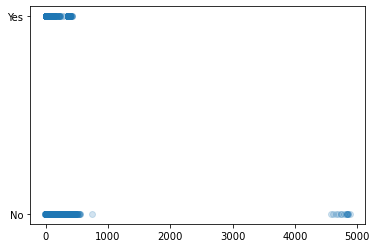

In [58]:
plt.scatter(data_raw['Duration'], data_raw['Claim'], alpha=0.2)
pass

Присутствуют выбросы в правой нижней части графика. Стоит предполагать, что путешествия больше 4000 дней, вероятно, являются ошибкой в данных.

In [59]:
data_raw['Duration'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005      1.0
0.010      1.0
0.050      3.0
0.100      5.0
0.500     22.0
0.900    109.0
0.950    190.0
0.990    374.0
0.995    388.0
Name: Duration, dtype: float64

99,5% значений продолжительности путешествия меньше 388 дней. Значения больше этого можно выбросить.

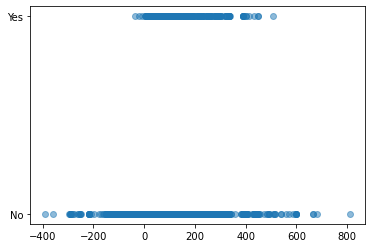

In [60]:
plt.scatter(data_raw['Net Sales'], data_raw['Claim'], alpha=0.5)
pass

На графике прибыли видны выбросы слева и справа снизу.

In [61]:
data_raw['Net Sales'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005    -49.5000
0.010    -12.0000
0.050      4.8825
0.100     10.0000
0.500     26.5300
0.900     80.0000
0.950    112.0000
0.990    252.8500
0.995    291.7500
Name: Net Sales, dtype: float64

99% значений лежат в пределах от -49.5 до 291.75.

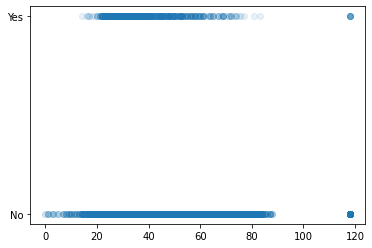

In [62]:
plt.scatter(data_raw['Age'], data_raw['Claim'], alpha=0.1)
pass

На графике возраста виден выброс около отметки в 120 лет. Скорее всего, это тоже ошибка в данных.

In [63]:
data_raw['Age'].quantile([0.005,.01,.05,.1,.5,.9,.95,.98,.995])

0.005     20.0
0.010     21.0
0.050     25.0
0.100     28.0
0.500     36.0
0.900     55.0
0.950     63.0
0.980     75.0
0.995    118.0
Name: Age, dtype: float64

Четкий выброс на графике соответствует возрасту 118 лет, 98% всех значений меньше. Также можно выбросить значения, которых меньше чем 0.5%

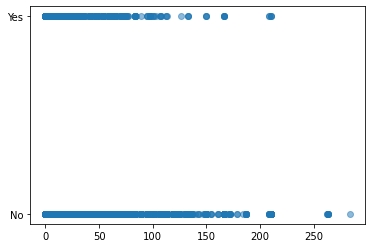

In [64]:
plt.scatter(data_raw['Commision'], data_raw['Claim'], alpha=0.5)
pass

На графике значений комиссии справа присутствуют выбросы.

In [65]:
data_raw['Commision'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005      0.00
0.010      0.00
0.050      0.00
0.100      0.00
0.500      0.00
0.900     29.70
0.950     51.13
0.990     89.10
0.995    112.86
Name: Commision, dtype: float64

99.5% значений меньше 112.86. Остальные значения можно выбросить.

Удаляем строки таблицы, соответствующие выбросам

In [66]:
rows_to_drop = data_raw[
    (data_raw['Duration'] > data_raw['Duration'].quantile(0.995)) | 
    (data_raw['Net Sales']  < data_raw['Net Sales' ].quantile(0.005)) | (data_raw['Net Sales']  > data_raw['Net Sales' ].quantile(0.995)) | 
    (data_raw['Age']  < data_raw['Age' ].quantile(0.005)) | (data_raw['Age']  > data_raw['Age' ].quantile(0.98)) |
    (data_raw['Commision']  > data_raw['Commision' ].quantile(0.995))].index
data = data_raw.drop(rows_to_drop)
data.shape

(60782, 11)

## Преобразование категориальных признаков

Преобразуем номинальные признаки в специальный категориальный тип. Сейчас они имеют тип объекта.

In [67]:
data['Agency'] = data['Agency'].astype('category')
data['Agency Type'] = data['Agency Type'].astype('category')
data['Distribution Channel'] = data['Distribution Channel'].astype('category')
data['Product Name'] = data['Product Name'].astype('category')
data['Destination'] = data['Destination'].astype('category')
data['Gender'] = data['Gender'].astype('category')

In [68]:
data['Gender'].dtype

CategoricalDtype(categories=['F', 'M'], ordered=False)

# 2. Визуализация и вычисление основных характеристик

In [69]:
data.describe()

,Duration,Net Sales,Commision,Age
count,60782.000000,60782.000000,60782.000000,60782.000000
mean,44.561745,38.383437,8.293383,38.630499
std,65.412176,38.869487,15.382017,9.615026
min,0.000000,-49.500000,0.000000,20.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.000000,0.000000,36.000000
75%,51.000000,46.000000,10.000000,42.000000
max,388.000000,291.750000,112.860000,75.000000


В таблице показаны только численные признаки.
Описание таблицы:
1. Так как в рассматриваемом датасете пропуски присутствуют только в категориальном признаке Gender, то количество численных признаков одинаково и равно количеству всех строк в датасете
2. Среднее значение
3. Стандартное отклонение
4. Минимальное значение
5. Первый квартиль
6. Медиана
7. Третий квартиль
8. Максимальное значение
Стоит отметить, что как минимум в половине случаев агентство не брало комиссию за оформление полиса.

Выведем информацию для категориальных признаков:

In [70]:
data.describe(include=['category'])

,Agency,Agency Type,Distribution Channel,Product Name,Destination,Gender
count,60782,60782,60782,60782,60782,16250
unique,15,2,2,24,146,2
top,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE,M
freq,34916,44978,59922,18538,12559,8257


Описание таблицы:
1. Количество строк, где признак указан. Видно, что признак Gender имеет довольно большое число пропусков значений
2. Количество уникальных значений
3. Наиболее часто встречающееся значение
4. Частота этого значения

Выведем некоторые зависимости в виде графиков:

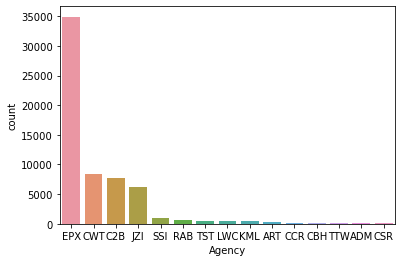

In [71]:
sns.countplot(x='Agency', data = data, order = data['Agency'].value_counts().index)
pass

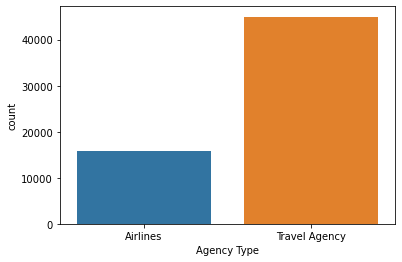

In [72]:
sns.countplot(x='Agency Type', data = data)
pass

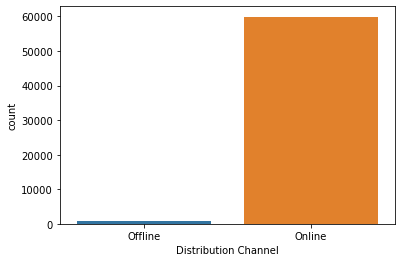

In [73]:
sns.countplot(x='Distribution Channel', data = data)
pass

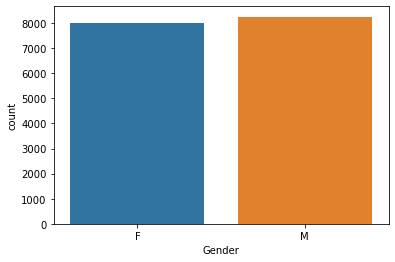

In [74]:
sns.countplot(x = 'Gender', data = data)
pass

Выведем график всех пар. Для этого выделим случайное подмножество из датасета random_subset. Это необходимо для того, чтобы не загромождать графики и ускорить их обработку.

In [75]:
np.random.seed(100)
random_subset = np.random.choice(np.arange(data.shape[0]), size = 1000, replace = False)

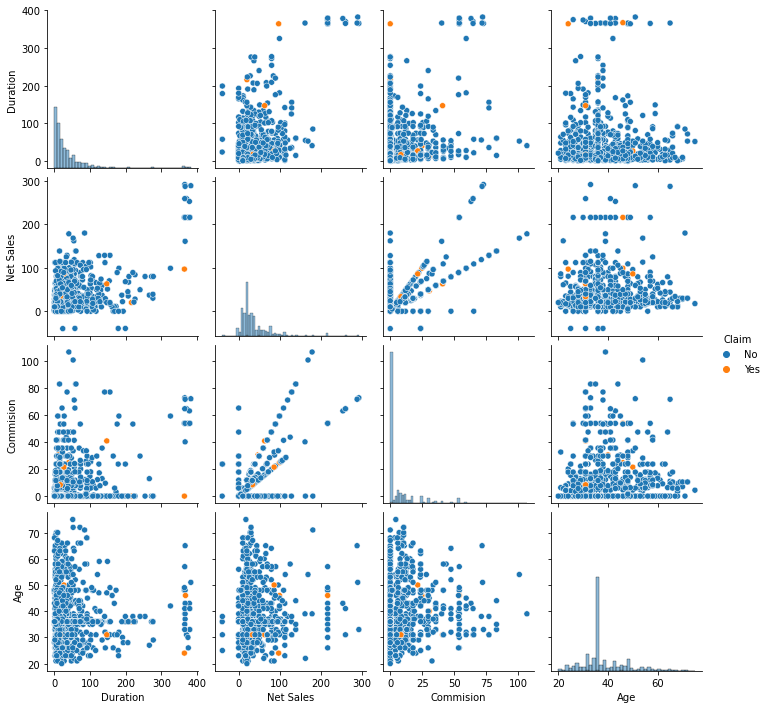

In [76]:
sns.pairplot(data.iloc[random_subset], diag_kind = 'hist', hue = 'Claim')
pass

Посчитаем корреляционную матрицу:

In [77]:
corr_matr = data.corr()
corr_matr

,Duration,Net Sales,Commision,Age
Duration,1.000000,0.565808,0.364603,0.014525
Net Sales,0.565808,1.000000,0.600208,0.024196
Commision,0.364603,0.600208,1.000000,0.127943
Age,0.014525,0.024196,0.127943,1.000000


Видно, что высокую степень корреляции (более 0.5) имеют следующие пары признаков: Duration и Net Sales, Net Sales и Commision. Эти признаки сильно связаны. Более слабую связь имеет пара Duration и Commision, остальные пары имеют еще более слабую степень корреляции.

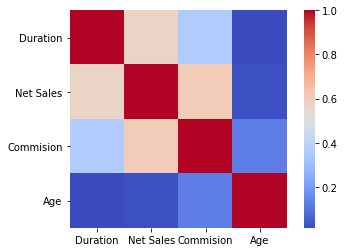

In [78]:
sns.heatmap(corr_matr, square=True, cmap='coolwarm')
pass

# 3. Обработка пропущенных значений

In [79]:
data.isna().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Claim                       0
Duration                    0
Destination                 0
Net Sales                   0
Commision                   0
Gender                  44532
Age                         0
dtype: int64

Пропущенные значения имеет только столбец Gender. Число значений достаточно велико, поэтому нельзя выбросить такие объекты. Если их выбросить, то в датасете значительная часть информации будет утеряна.

Заполним недостающие значения при помощи моды признака Gender. Его мода:

In [80]:
data['Gender'].mode()

0    M
Name: Gender, dtype: category
Categories (2, object): ['F', 'M']

Заполняем отсутствующие значений модой:

In [81]:
data['Gender'].fillna(data['Gender'].mode()[0], inplace = True)

In [82]:
data.isna().sum()

Agency                  0
Agency Type             0
Distribution Channel    0
Product Name            0
Claim                   0
Duration                0
Destination             0
Net Sales               0
Commision               0
Gender                  0
Age                     0
dtype: int64

Таким образом мы заполнили все пропуски.

# 4. Обработка категориальных признаков

Бинарные признаки Agency Type, Distribution Channel и Gender можно заполнить при помощи факторизации. Эти признаки будут представлены в виде значений 0 и 1.

In [83]:
data['Agency Type'] = pd.factorize(data['Agency Type'])[0]
data['Distribution Channel'] = pd.factorize(data['Distribution Channel'])[0]
data['Gender'] = pd.factorize(data['Gender'])[0]

Подобным образом факторизуем целевой признак Claim:

In [84]:
data['Claim'] = pd.factorize(data['Claim'])[0]
data

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision,Gender,Age
1,CBH,0,0,Comprehensive Plan,0,186,MALAYSIA,-29.0,9.57,0,71
2,CWT,0,1,Rental Vehicle Excess Insurance,0,65,AUSTRALIA,-49.5,29.70,1,32
3,CWT,0,1,Rental Vehicle Excess Insurance,0,60,AUSTRALIA,-39.6,23.76,1,32
4,CWT,0,1,Rental Vehicle Excess Insurance,0,79,ITALY,-19.8,11.88,1,41
6,CWT,0,1,Rental Vehicle Excess Insurance,0,47,UNITED STATES,-39.6,23.76,1,32
...,...,...,...,...,...,...,...,...,...,...,...
63321,JZI,1,1,Basic Plan,0,111,JAPAN,35.0,12.25,1,31
63322,JZI,1,1,Basic Plan,0,58,CHINA,40.0,14.00,0,40
63323,JZI,1,1,Basic Plan,0,2,MALAYSIA,18.0,6.30,1,57
63324,JZI,1,1,Basic Plan,0,3,VIET NAM,18.0,6.30,1,63


Для остальных категориальных признаков воспользуемся методом векторизации. К примеру, для признака Agency генерируются следующие фиктивные столбцы:

In [85]:
Agency_dummies = pd.get_dummies(data['Agency'])
Agency_dummies

,ADM,ART,C2B,CBH,CCR,CSR,CWT,EPX,JZI,KML,LWC,RAB,SSI,TST,TTW
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63321,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
63322,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
63323,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
63324,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


Присоединяем эти столбцы к таблице и удаляем оригинальный столбец Agency:

In [86]:
data = pd.concat((data, Agency_dummies), axis = 1)
data = data.drop(['Agency'], axis = 1)
data

,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision,Gender,Age,...,CSR,CWT,EPX,JZI,KML,LWC,RAB,SSI,TST,TTW
1,0,0,Comprehensive Plan,0,186,MALAYSIA,-29.0,9.57,0,71,...,0,0,0,0,0,0,0,0,0,0
2,0,1,Rental Vehicle Excess Insurance,0,65,AUSTRALIA,-49.5,29.70,1,32,...,0,1,0,0,0,0,0,0,0,0
3,0,1,Rental Vehicle Excess Insurance,0,60,AUSTRALIA,-39.6,23.76,1,32,...,0,1,0,0,0,0,0,0,0,0
4,0,1,Rental Vehicle Excess Insurance,0,79,ITALY,-19.8,11.88,1,41,...,0,1,0,0,0,0,0,0,0,0
6,0,1,Rental Vehicle Excess Insurance,0,47,UNITED STATES,-39.6,23.76,1,32,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63321,1,1,Basic Plan,0,111,JAPAN,35.0,12.25,1,31,...,0,0,0,1,0,0,0,0,0,0
63322,1,1,Basic Plan,0,58,CHINA,40.0,14.00,0,40,...,0,0,0,1,0,0,0,0,0,0
63323,1,1,Basic Plan,0,2,MALAYSIA,18.0,6.30,1,57,...,0,0,0,1,0,0,0,0,0,0
63324,1,1,Basic Plan,0,3,VIET NAM,18.0,6.30,1,63,...,0,0,0,1,0,0,0,0,0,0


Проделываем эти операции для остальных признаков:

In [87]:
Product_name_dummies = pd.get_dummies(data['Product Name'])
Destination_dummies = pd.get_dummies(data['Destination'])
data = pd.concat((data, Product_name_dummies, Destination_dummies), axis = 1)
data = data.drop(['Product Name', 'Destination'], axis = 1)
data

,Agency Type,Distribution Channel,Claim,Duration,Net Sales,Commision,Gender,Age,ADM,ART,...,UNITED KINGDOM,UNITED STATES,URUGUAY,UZBEKISTAN,VANUATU,VENEZUELA,VIET NAM,"VIRGIN ISLANDS, U.S.",ZAMBIA,ZIMBABWE
1,0,0,0,186,-29.0,9.57,0,71,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,65,-49.5,29.70,1,32,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,60,-39.6,23.76,1,32,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,79,-19.8,11.88,1,41,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,0,47,-39.6,23.76,1,32,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63321,1,1,0,111,35.0,12.25,1,31,0,0,...,0,0,0,0,0,0,0,0,0,0
63322,1,1,0,58,40.0,14.00,0,40,0,0,...,0,0,0,0,0,0,0,0,0,0
63323,1,1,0,2,18.0,6.30,1,57,0,0,...,0,0,0,0,0,0,0,0,0,0
63324,1,1,0,3,18.0,6.30,1,63,0,0,...,0,0,0,0,0,0,1,0,0,0


# 5. Нормализация признаков

Нормализуем признаки при помощи линейного преобразования к отрезку [0, 1]:

In [88]:
data_normalized = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
data_normalized.describe()

,Agency Type,Distribution Channel,Claim,Duration,Net Sales,Commision,Gender,Age,ADM,ART,...,UNITED KINGDOM,UNITED STATES,URUGUAY,UZBEKISTAN,VANUATU,VENEZUELA,VIET NAM,"VIRGIN ISLANDS, U.S.",ZAMBIA,ZIMBABWE
count,60782.000000,60782.000000,60782.000000,60782.000000,60782.000000,60782.000000,60782.000000,60782.000000,60782.000000,60782.000000,...,60782.000000,60782.000000,60782.000000,60782.000000,60782.000000,60782.000000,60782.000000,60782.000000,60782.000000,60782.000000
mean,0.260011,0.985851,0.014017,0.114850,0.257534,0.073484,0.868497,0.338736,0.001135,0.004475,...,0.020829,0.037741,0.000016,0.000165,0.000082,0.000082,0.027409,0.000016,0.000033,0.000049
std,0.438644,0.118106,0.117563,0.168588,0.113903,0.136293,0.337952,0.174819,0.033674,0.066746,...,0.142811,0.190572,0.004056,0.012826,0.009069,0.009069,0.163275,0.004056,0.005736,0.007025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.023196,0.197802,0.000000,1.000000,0.272727,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.056701,0.221245,0.000000,1.000000,0.290909,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.131443,0.279853,0.088605,1.000000,0.400000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 6. Разбивка данных на обучающие и тестовые признаки

Выделяем целевой столбец из таблицы:

In [89]:
X = data_normalized.drop(['Claim'], axis = 1)
y = data_normalized['Claim']

Разбиваем данные на обучающую и тестовую выборки в соотношении 3:1, т.е. в обучающую выборку попадет 75% объектов, в тестовую 25%

In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 100)

N_train = X_train.shape[0]
N_test = X_test.shape[0]
N_train, N_test

(45586, 15196)

# 7. Классификатор ближайших соседей

По-умолчанию количество ближайших соседей 5:

In [91]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

Попробуем с количеством соседей K = 1:

In [92]:
knn_1 = KNeighborsClassifier(n_neighbors = 1)
knn_1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

С количеством соседей K = 8:

In [93]:
knn_8 = KNeighborsClassifier(n_neighbors = 8)
knn_8.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

# 8. Ошибки на обучающей и тестовой выборках

In [94]:
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
y_train_score = np.mean(y_train != y_train_pred)
y_test_score = np.mean(y_test != y_test_pred)
y_train_score, y_test_score

(0.013885842144518054, 0.014477494077388787)

При использовании 5 ближайших соседей на обучающей выборке ошибка получилась 1.39%, на тестовой 1.44%

In [95]:
y_train_pred = knn_1.predict(X_train)
y_test_pred = knn_1.predict(X_test)
y_train_score = np.mean(y_train != y_train_pred)
y_test_score = np.mean(y_test != y_test_pred)
y_train_score, y_test_score

(0.0012942570087307508, 0.027244011581995263)

При K = 1 на обучающей выборке ошибка получилась 0.13%, на тестовой 2.72%

In [96]:
y_train_pred = knn_8.predict(X_train)
y_test_pred = knn_8.predict(X_test)
y_train_score = np.mean(y_train != y_train_pred)
y_test_score = np.mean(y_test != y_test_pred)
y_train_score, y_test_score

(0.013951651822928093, 0.014411687286127928)

При K = 8 ошибки 1.39% и 1.45% соответственно

Использование классификатора ближайших соседей с количеством соседей 5 дает хороший результат на выборке. Увеличение количества соседей не приводит к улучушению результата, значения ошибки остаются неизменными.
Однако при уменьшении количества ближайших соседей увеличивается ошибка на тестовой выборке (хотя и уменьшается на обучающей).

# 9. Другие классификаторы

## Random Forest

In [97]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

print(err_train, err_test)

0.0011626376519106743 0.016188470650171097


Случайный лес показывает хороший результат на обучающей выборке, но на тестовой выборке ошибка чуть выше, чем в методе kNN.

Выведем значимость признаков:

In [98]:
np.sum(rf.feature_importances_)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(indices.shape[0]):
    print("%2d. feature '%5s' (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
 1. feature 'Duration' (0.356240)
 2. feature '  Age' (0.292905)
 3. feature 'Net Sales' (0.167230)
 4. feature 'Commision' (0.093283)
 5. feature 'Gender' (0.013822)
 6. feature '  C2B' (0.007976)
 7. feature 'SINGAPORE' (0.004142)
 8. feature 'Annual Silver Plan' (0.004005)
 9. feature 'Silver Plan' (0.002921)
10. feature 'Bronze Plan' (0.002911)
11. feature 'Agency Type' (0.002568)
12. feature 'THAILAND' (0.002421)
13. feature 'AUSTRALIA' (0.002362)
14. feature 'MALAYSIA' (0.002333)
15. feature 'UNITED KINGDOM' (0.002048)
16. feature 'JAPAN' (0.001902)
17. feature 'UNITED STATES' (0.001772)
18. feature 'CHINA' (0.001757)
19. feature 'HONG KONG' (0.001590)
20. feature 'Cancellation Plan' (0.001528)
21. feature 'CANADA' (0.001524)
22. feature '  EPX' (0.001360)
23. feature '2 way Comprehensive Plan' (0.001344)
24. feature 'VIET NAM' (0.001255)
25. feature 'TAIWAN, PROVINCE OF CHINA' (0.001205)
26. feature 'NEW ZEALAND' (0.001199)
27. feature 'ITALY' (0.001194)
28. fea

Наиболее значимыми признаками являются Duration, Age, Net Sales, Commision. Остальные признаки вносят меньший вклад в предсказание результата.

## Decision Tree

In [99]:
from sklearn.tree import DecisionTreeClassifier
desTrCl = DecisionTreeClassifier()
desTrCl.fit(X_train,y_train)

print ('Depth:', desTrCl.get_depth())
print ('Leaves:', desTrCl.get_n_leaves())

err_train = np.mean(y_train != desTrCl.predict(X_train))
err_test  = np.mean(y_test  != desTrCl.predict(X_test))

print(err_train, err_test)

Depth: 35
Leaves: 1614
0.0011626376519106743 0.028165306659647275


Деревья решений также показывают хороший результат на обучающей выборке, но на тестовой выборке ошибка выше, чем в других методах.

## SVC

In [100]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))

print(err_train, err_test)

0.013907778703988067 0.014345880494867071


Машина опорных векторов на данном датасете показывает похожий результат на kNN.

# 12. Общие выводы

В данной работе был проведен анализ датасета, содержащего данные о туристических страховках. Целевым признаком, который было необходимо предсказать, являлся категориальный признак Claim - наступление страхового случая по страховке. Была решена задача классификации с использованием методов kNN, Random Forest, Decision Tree, SVC.
Проведенные этапы работы:
1. Чтение данных, преобразование категориальных признаков, обработка выбросов
2. Визуализация и вычисление основных характеристик
3. Обработка пропущенных значений
4. Обработка категориальных признаков
5. Нормализация данных при помощи линейного преобразования к отрезку
6. Разбиение данных на обучающие и тестовые выборки
7. Запуск классификатора kNN
8. Вычисление ошибок
9. Запуск других классификаторов: случаный лес, деревья решений, машина опорных векторов
10. Выводы

Вывод по работе алгоритмов на данном датасете: kNN с числом соседей более 5 и SVC показали наилучшие результаты на тестовых выборках. Методы Random Forest и Decision Tree показали хорошие результаты с низким значением ошибки только на обучающей выборке, как и kNN с одним соседом.